# Проект: ML Предсказание стоимости жилья за 1990 год в Калифорнии, США

## Описание проекта

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:
* `longitude` — широта;
* `latitude` — долгота;
* `housing_median_age` — медианный возраст жителей жилого массива;
* `total_rooms` — общее количество комнат в домах жилого массива;
* `total_bedrooms` — общее количество спален в домах жилого массива;
* `population` — количество человек, которые проживают в жилом массиве;
* `households` — количество домовладений в жилом массиве;
* `median_income` — медианный доход жителей жилого массива;
* `median_house_value` — медианная стоимость дома в жилом массиве;
* `ocean_proximity` — близость к океану.

### ЗАДАЧИ
* На основе данных нужно предсказать медианную стоимость дома в жилом массиве — `median_house_value`. 
* Обучить модель и сделать предсказания на тестовой выборке. 
* Для оценки качества модели будем испольщовать метрики **RMSE**, **MAE** и **R2**.

### План проекта

1. Инициализируем локальную Spark-сессию.
2. Прочитаем содержимое файла `/datasets/housing.csv`.
3. Выведем типы данных колонок датасета. Используем методы pySpark.
4. Выполним предобработку данных:
5. Исследуем данные на наличие пропусков и заполним их, выбрав значения по своему усмотрению.
6. Преобразуем колонку с категориальными значениями техникой One hot encoding.
7. Построим две модели линейной регрессии на разных наборах данных:
  * используя все данные из файла;
  * используя только числовые переменные, исключив категориальные.
8. Для построения модели используем оценщик LinearRegression из библиотеки MLlib.
9. Сравним результаты работы линейной регрессии на двух наборах данных по метрикам RMSE, MAE и R2.
10. Общий вывод

## Подготовка данных

### Библиотеки и окружение

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import phik
from phik import resources, report

import pyspark
from pyspark import keyword_only

from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.types import *
from pyspark.sql.types import NumericType, FloatType, DoubleType
import pyspark.sql.functions as F
from pyspark.sql.functions import skewness, udf, col, log1p, expr

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder, Imputer, SQLTransformer
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.param.shared import HasInputCols, HasOutputCol, Param, Params, TypeConverters


### Инициализация функций

In [2]:
def plot_kde_numeric_features(df):
    """
    Функция для создания графиков KDE для всех числовых переменных в DataFrame.
    Параметры:
        df (pyspark.sql.dataframe.DataFrame): DataFrame, для которого требуется создать графики.
    """
    numeric_features = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]
    
    for feature in numeric_features:
        # Собираем данные столбца
        data = df.select(feature).na.drop().rdd.flatMap(lambda x: x).collect()
        
        # Создаем график KDE
        plt.figure(figsize=(10, 6))
        sns.kdeplot(data, shade=True, color="r", alpha=0.5, linewidth=1.5)
        plt.title(f'KDE для {feature}')
        plt.xlabel(feature)
        plt.ylabel('Плотность')
        plt.grid(True)
        plt.show()

In [3]:
def calculate_skewness(df: DataFrame):
    """
    Функция для измерения асимметрии числовых столбцов в PySpark DataFrame.
    
    Параметры:
    - df (DataFrame): PySpark DataFrame с числовыми столбцами для анализа.
    
    Возвращает:
    - Список кортежей с именем столбца и его асимметрией.
    """
    # Определение числовых столбцов
    numeric_columns = [field.name for field in df.schema.fields if isinstance(field.dataType, NumericType)]
    
    # Список для хранения результатов
    skewness_results = []
    
    for column in numeric_columns:
        # Вычисление асимметрии для каждого числового столбца
        skewness_value = df.select(skewness(df[column])).collect()[0][0]
        
        # Добавление результата в список
        skewness_results.append((column, skewness_value))
    
    # Вывод результатов
    for result in skewness_results:
        print(f"Skewness of {result[0]}: {result[1]}")

In [4]:
#def create_correlation_heatmaps(df_spark):
#    # Конвертация Spark DataFrame в Pandas DataFrame
#    df_pandas = df_spark.toPandas()
#    
#    # Корреляция Pearson для непрерывных переменных
#    plt.figure(figsize=(10, 8))
#    plt.title('Pearson Correlation Matrix')
#    sns.heatmap(df_pandas.corr(method='pearson'), annot=True, fmt=".2f", cmap='bwr')
#    plt.show()
#    
#    # Корреляция phik для всех типов переменных, включая категориальные
#    plt.figure(figsize=(10, 8))
#    plt.title('Phik Correlation Matrix')
#    phik_matrix = df_pandas.phik_matrix()
#    sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='seismic')
#    plt.show()

In [5]:
# def create_correlation_heatmaps(df_spark):
#     # Конвертация Spark DataFrame в Pandas DataFrame
#     df_pandas = df_spark.toPandas()
#     
#     # Корреляция Pearson для непрерывных переменных
#     pearson_corr = df_pandas.corr(method='pearson')
#     print("Pearson Correlation Matrix:")
#     print(pearson_corr)
#     plt.figure(figsize=(10, 8))
#     plt.title('Pearson Correlation Matrix')
#     sns.heatmap(pearson_corr, annot=True, fmt=".2f", cmap='bwr')
#     plt.show()
#     
#     # Корреляция phik для всех типов переменных, включая категориальные
#     phik_matrix = df_pandas.phik_matrix( interval_cols = ['longitude', 
#                                                            'latitude', 
#                                                           'housing_median_age', 
#                                                           'total_rooms', 
#                                                           'total_bedrooms', 
#                                                           'population',
#                                                           'households', 
#                                                           'median_income', 
#                                                           'median_house_value'])
#    print("Phik Correlation Matrix:")
#    print(phik_matrix)
#    plt.figure(figsize=(10, 8))
#    plt.title('Phik Correlation Matrix')
#    sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='seismic')
#    plt.show()

In [6]:
# Функция для логарифмического преобразования столбцов
def log_transform(df, columns):
    for column in columns:
        df = df.withColumn(column, log1p(df[column]))
    return df

In [7]:
def create_phik_heatmap(df_spark, sample_fraction=0.2):
    """
    Создает тепловую карту корреляции PhiK для сэмплированных данных из Spark DataFrame.
    
    Аргументы:
    df_spark (Spark DataFrame): Исходный DataFrame.
    sample_fraction (float): Доля выборки для сэмплирования. По умолчанию 0.1.
    """
    # Сэмплирование данных
    sampled_df = df_spark.sample(fraction=sample_fraction).toPandas()
    
    # Вычисление матрицы корреляции PhiK
    phik_matrix = sampled_df.phik_matrix()
    
    # Визуализация тепловой карты
    plt.figure(figsize=(12, 10))
    plt.title('PhiK Correlation Matrix (Sampled Data)')
    sns.heatmap(phik_matrix, annot=True, fmt=".2f", cmap='viridis', vmin=-1, vmax=1)
    plt.show()

### Инициализация Spark

In [8]:
# настройка параметров Spark-сессии
spark = SparkSession.builder \
                    .master("local") \
                    .appName("House pricing in California, USA") \
                    .getOrCreate()

In [9]:
df = spark.read.load('/datasets/housing.csv', format='csv', sep=',', inferSchema=True, header='true')
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [10]:
df_pipe = df.alias("df_pipe")

### Обзор данных

In [11]:
pd.DataFrame(df.dtypes, columns=['column', 'type'])

,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [12]:
df.show(10)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

In [13]:
df.describe().select(
    'summary',
    F.round('housing_median_age',4).alias('housing_median_age'),
    F.round('total_rooms',4).alias('total_rooms'),
    F.round('total_bedrooms',4).alias('total_bedrooms'),
    F.round('population',4).alias('population'),
    F.round('households', 4).alias("households"),
    F.round('median_income', 4).alias("median_income"),
    F.round('median_house_value', 4).alias('median_house_value')
).toPandas()

,summary,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,count,20640.0000,20640.0000,20433.0000,20640.0000,20640.0000,20640.0000,20640.0000
1,mean,28.6395,2635.7631,537.8706,1425.4767,499.5397,3.8707,206855.8169
2,stddev,12.5856,2181.6153,421.3851,1132.4621,382.3298,1.8998,115395.6159
3,min,1.0000,2.0000,1.0000,3.0000,1.0000,0.4999,14999.0000
4,max,52.0000,39320.0000,6445.0000,35682.0000,6082.0000,15.0001,500001.0000


### Работа с пропусками

In [14]:
columns = df.columns
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


`total_bedrooms` содержит 207 пропусков. Чтобы выбрать значения для заполнения, нужно посмотреть как распределяется переменная.

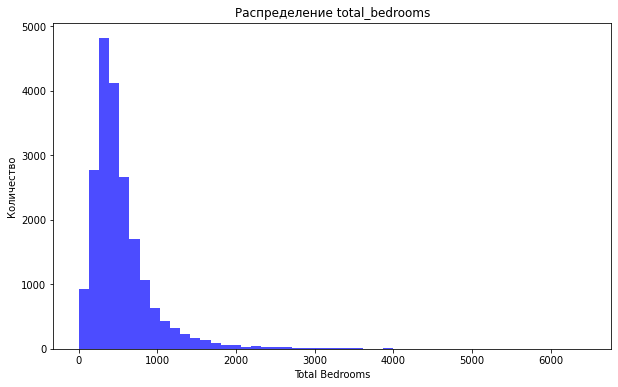

In [15]:
df_no_missing = df.na.drop(subset=["total_bedrooms"])
bedrooms_data = df_no_missing.select('total_bedrooms').rdd.flatMap(lambda x: x).collect()

# Визуализация распределения
plt.figure(figsize=(10, 6))
plt.hist(bedrooms_data, bins=50, color='blue', alpha=0.7)
plt.title('Распределение total_bedrooms')
plt.xlabel('Total Bedrooms')
plt.ylabel('Количество')
plt.show()

Распределение похоже на нормальное, но с длинным правым хвостом содержащим большое кол-во выбросов. \
Лучше заполнить пропуск медианой.

In [16]:
# Создаем объект Imputer
#imputer = Imputer(inputCols=['total_bedrooms'], 
#                  outputCols=['total_bedrooms'],
#                  strategy='median')

# Обучаем imputer на данных (рассчитываем медиану)
# df = imputer.fit(df).transform(df)

# Посмотрим на пропуски
#for column in columns:
#    check_col = F.col(column).isNull()
#    print(column, df.filter(check_col).count())

In [17]:
# Вычисление медианы для 'total_bedrooms'
median_value = df.agg(expr('percentile_approx(total_bedrooms, 0.5) as median')).collect()[0]['median']

# Заполнение пропусков медианным значением
df = df.na.fill({'total_bedrooms': median_value})

# Показать результаты
df.select('total_bedrooms').show(10)

+--------------+
|total_bedrooms|
+--------------+
|         129.0|
|        1106.0|
|         190.0|
|         235.0|
|         280.0|
|         213.0|
|         489.0|
|         687.0|
|         665.0|
|         707.0|
|         434.0|
|         752.0|
|         474.0|
|         191.0|
|         626.0|
|         283.0|
|         347.0|
|         293.0|
|         455.0|
|         298.0|
+--------------+
only showing top 20 rows



In [18]:
columns = df.columns
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


### Анализ данных

После заполнения пропусков, посмотрим, как распределяются числовые переменные.

In [19]:
df_num = df["housing_median_age",
'total_rooms',
'total_bedrooms',
'population',
'households',
"median_income",
"median_house_value"]


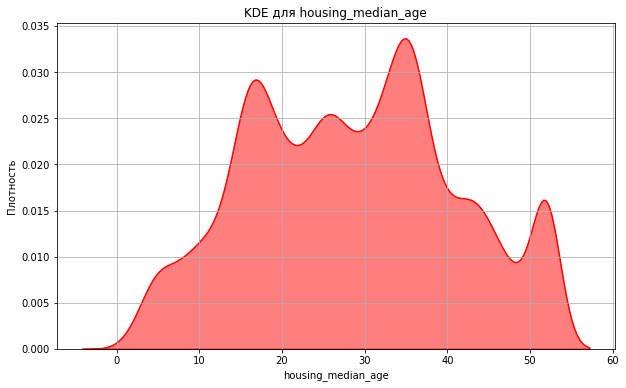

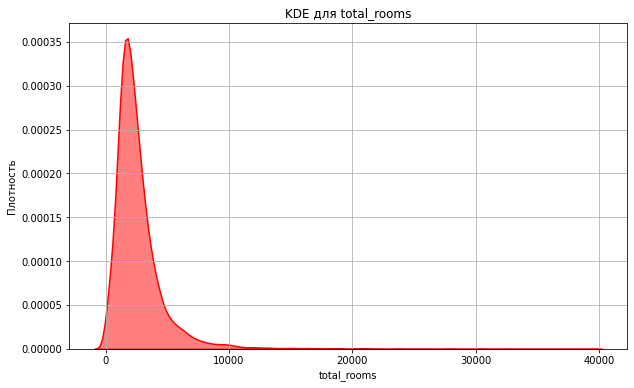

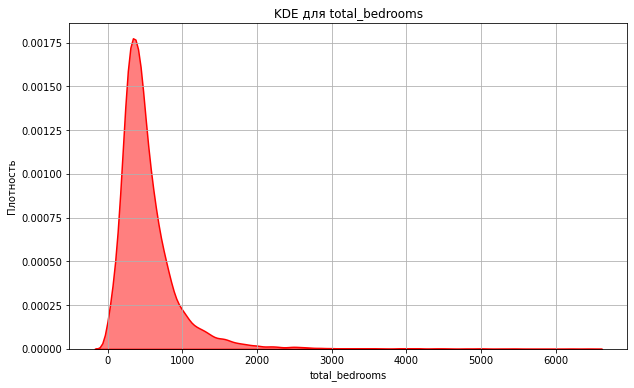

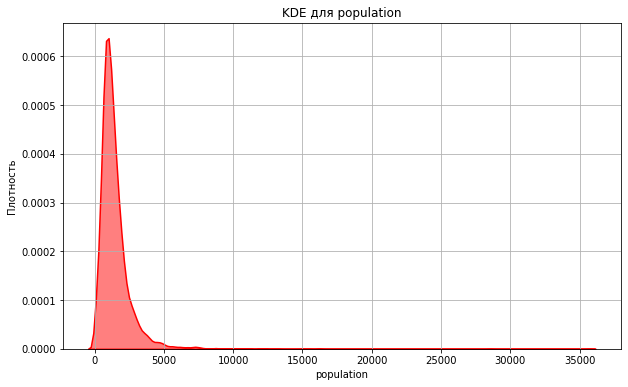

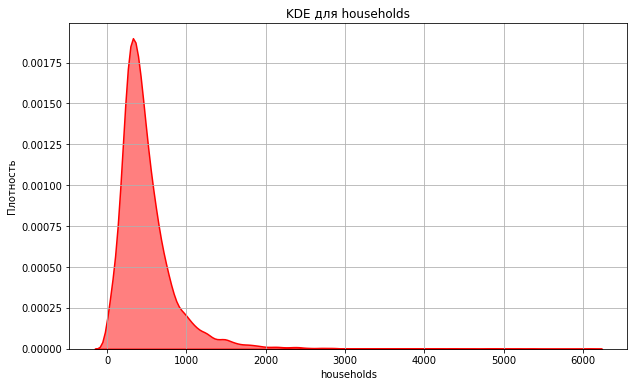

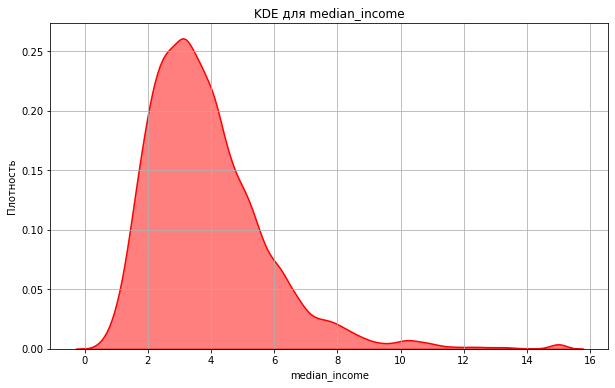

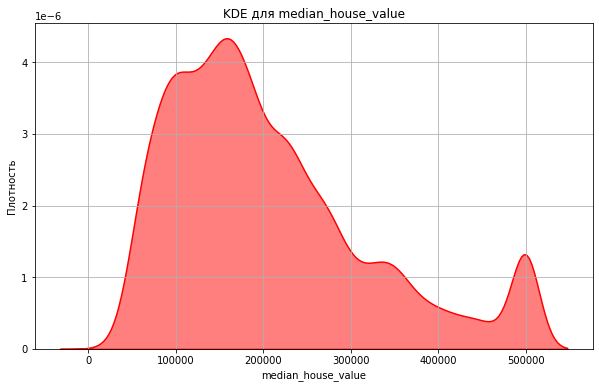

In [20]:
plot_kde_numeric_features(df_num)

In [21]:
calculate_skewness(df_num)

Skewness of housing_median_age: 0.060326253016608676
Skewness of total_rooms: 4.147042038773302
Skewness of total_bedrooms: 3.480887868105646
Skewness of population: 4.935499508858543
Skewness of households: 3.410189855085662
Skewness of median_income: 1.6465370299001063
Skewness of median_house_value: 0.9776922140978437


* У переменных `housing_median_age`, `median_house_value`, `median_income` показатель *Skewness* ближе всего к нормальному распределению.
* `total_rooms`, `total_bedrooms`, `population`, `households` - распределение сильно смещено вправо, возможно попробовать логарифмическое преобразование.

#### Рассмотрим категориальный признак.

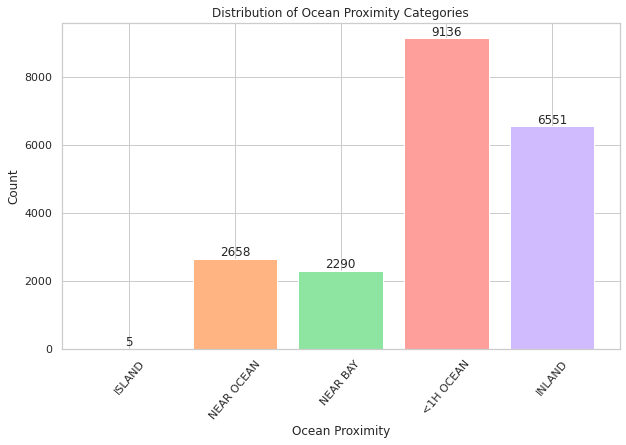

In [22]:
# Разделение данных на категории и количество
category_counts = df.groupBy("ocean_proximity").count().collect()
categories = [row[0] for row in category_counts]
counts = [row[1] for row in category_counts]

sns.set(style="whitegrid")
colors = sns.color_palette('pastel')[0:len(categories)]

plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.xlabel('Ocean Proximity')
plt.ylabel('Count')
plt.title('Distribution of Ocean Proximity Categories')
plt.xticks(rotation=50) 
plt.show()

* Большинство домохозяйств глубоко на суше либо в часе езды от океана.

#### Изучим корреляции в данных.

interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']


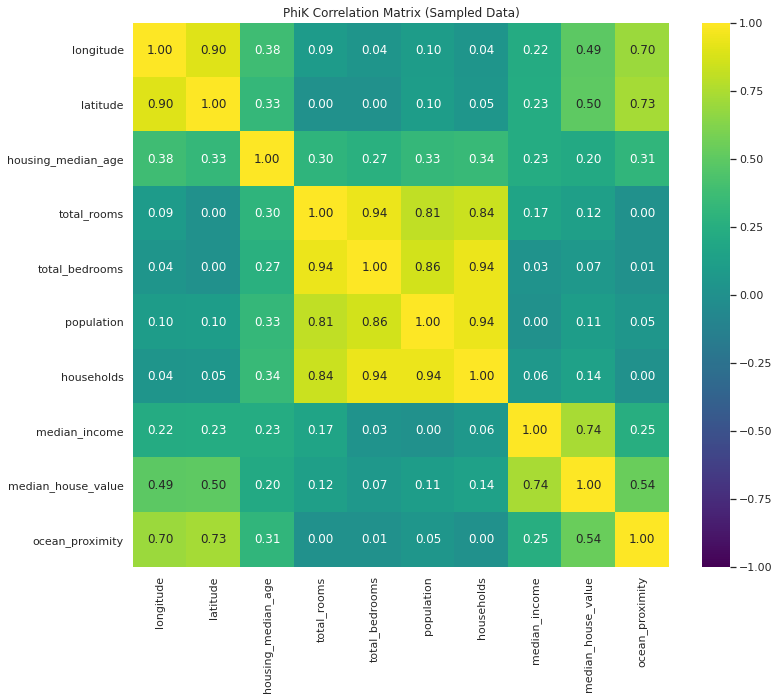

In [23]:
create_phik_heatmap(df, sample_fraction=0.2)

In [24]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

* Географическое положение: Корреляция между `longitude` и `latitude` отрицательная и очень сильная (-0.92), что говорит о том, что в этом географическом наборе данных широта и долгота меняются в противоположных направления
* Размеры недвижимости: `total_rooms`, `total_bedrooms`, `population` и `households` имеют высокую положительную корреляцию друг с другом (от 0.87 до 0.97), что логично, поскольку больше комнат обычно означает больше спален, большее население и больше домохозяйств.
* Доход: median_income имеет сильную положительную корреляцию с median_house_value (0.69), что является одним из самых значимых показателей в этом наборе данных. Это подразумевает, что доходы населения являются важным фактором в определении стоимости жилья.
* Стоимость жилья: Наименьшая корреляция median_house_value наблюдается с population (-0.02), что может указывать на то, что размер населения не имеет прямого влияния на медианную стоимость жилья.
* Географическая корреляция со стоимостью жилья: Интересно, что есть небольшая отрицательная корреляция между longitude и median_house_value (-0.046), а также между latitude и median_house_value (-0.144), что может отражать определенные региональные тенденции в стоимости недвижимости. 
* Далее попробуем исследовать и реализовать идею с географической зависимостью стоимости домовладения.

Пока что из вида мы упускали пару количественных переменных - `longitude` и `latitude`. \
Попробуем найти зависимость координат (широты и долготы от среднего дохода домовладения)

#### Разработаем новый признак

In [25]:
# Сохраним данные до каких-либо преобразований
df_copy = df.alias("df_copy")
df_copy.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

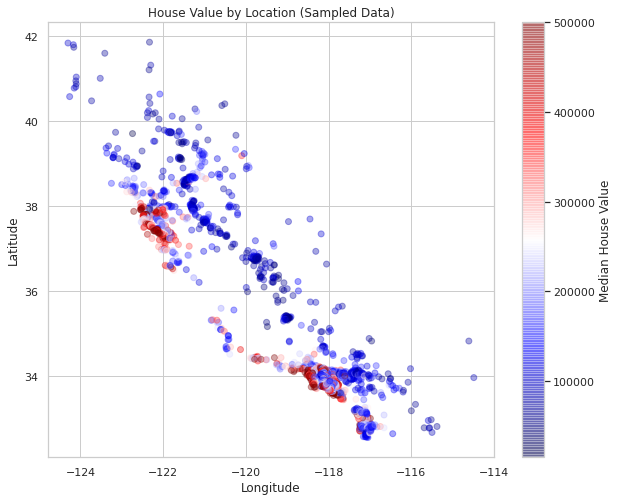

In [26]:
# Сэмплирование небольшой части данных для визуализации
sampled_df = df.sample(False, 0.1).collect()

# Использование результатов для визуализации
longitude = [row['longitude'] for row in sampled_df]
latitude = [row['latitude'] for row in sampled_df]
median_house_value = [row['median_house_value'] for row in sampled_df]

plt.figure(figsize=(10, 8))
plt.scatter(longitude, latitude, c=median_house_value, cmap='seismic', alpha=0.35)
plt.colorbar(label='Median House Value')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('House Value by Location (Sampled Data)')
plt.show()

Наблюдаются две области "высокой цены":
* Lat. : Long. : ~[37; -122.5] и ~[34; -118.5] - координаты на глаз.
* Возможно, по этим координатам распологается скопление богатых домовладений, т.е дорогой район.
* На вид наблюдается нелинейная связь координат с `median_house_value`.
* Создадим новый признак, который будет отражать удаленность от от двух координат с высокими значениями `median_house_value`.
* Оценивать удаленность будем с помошью формулы оценки Евклидова расстояния. 

In [27]:
rich_dist1 = [37, -122.5]
rich_dist2 = [34, -118.5]

In [28]:
# Функция для вычисления Евклидова расстояния
def calculate_euclid_dist(longitude, latitude, rich_dist1, rich_dist2):
    dist1 = np.sqrt((rich_dist1[0]-latitude)**2 + (rich_dist1[1]-longitude)**2)
    dist2 = np.sqrt((rich_dist2[0]-latitude)**2 + (rich_dist2[1]-longitude)**2)
    return float(np.min([dist1, dist2]))

# Регистрация UDF в Spark
hotspot_distance_udf = udf(lambda lon, 
                           lat: calculate_euclid_dist(lon, 
                                                      lat, 
                                                      rich_dist1, 
                                                      rich_dist2), FloatType())

# Добавление нового столбца с расстоянием до ближайшей точки
df = df.withColumn('rich_dist', hotspot_distance_udf(df['longitude'], df['latitude']))

In [29]:
df.select('rich_dist').show(10)

+----------+
| rich_dist|
+----------+
|  0.920489|
|0.90443355|
| 0.8888757|
|0.88600224|
|0.88600224|
|0.88600224|
|0.87641317|
|0.87641317|
| 0.8736132|
|0.87641317|
+----------+
only showing top 10 rows



In [30]:
correlation = df.stat.corr("rich_dist", "median_house_value")

print(f"Корреляция Пирсона между 'rich_dist' и 'median_house_value': {correlation}")

Корреляция Пирсона между 'rich_dist' и 'median_house_value': -0.474528496233286


interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rich_dist']


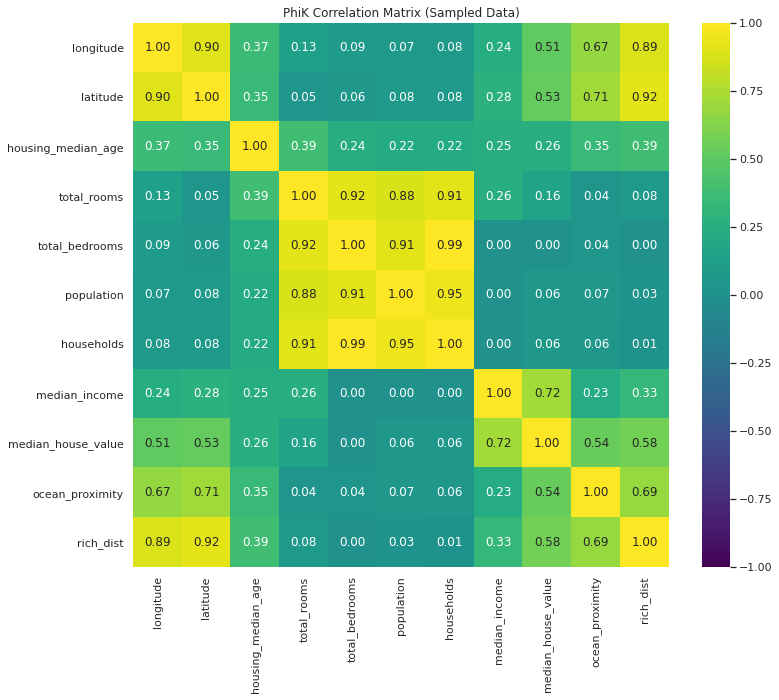

In [31]:
create_phik_heatmap(df, sample_fraction=0.2)

* Новая переменная имеет хорошую корреляцию с target-признаком. 
* Создание нового признака, думаю, можно считать удачным.

#### Логарифмическое преобразование

Попробуем взять логарифм от `total_rooms`, `total_bedrooms`, `population`, `households`. \
Посмотрим, как изменится распределение, разброс и корреляция.

In [32]:
# Список столбцов для логарифмического преобразования
columns_to_transform = ['total_rooms', 'total_bedrooms', 'population', 'households']

# Применение преобразования
df = log_transform(df, columns_to_transform)

interval columns not set, guessing: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'rich_dist']


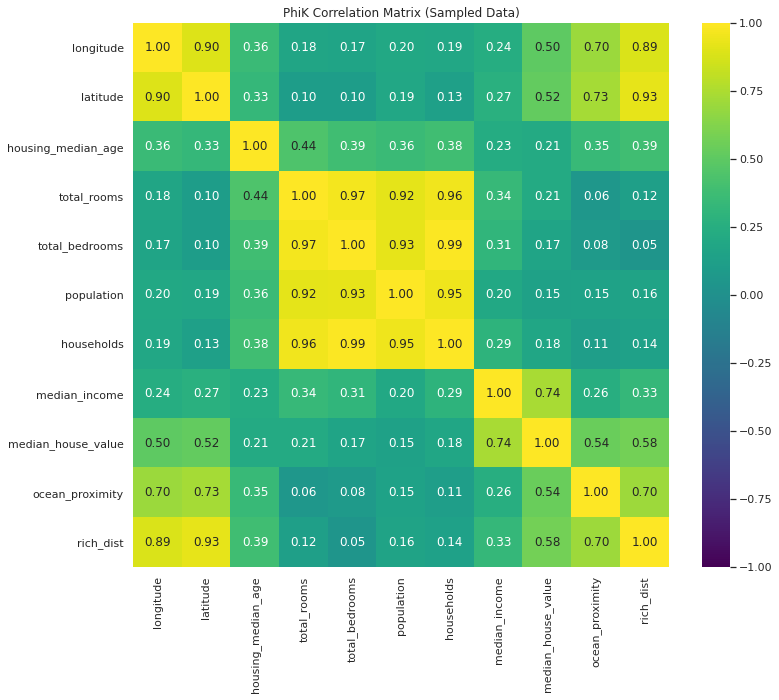

In [33]:
create_phik_heatmap(df, sample_fraction=0.2)

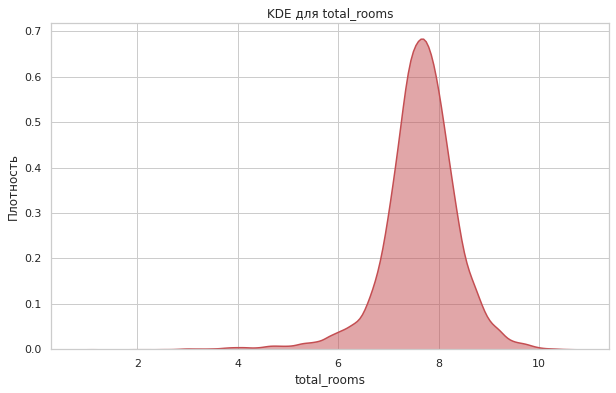

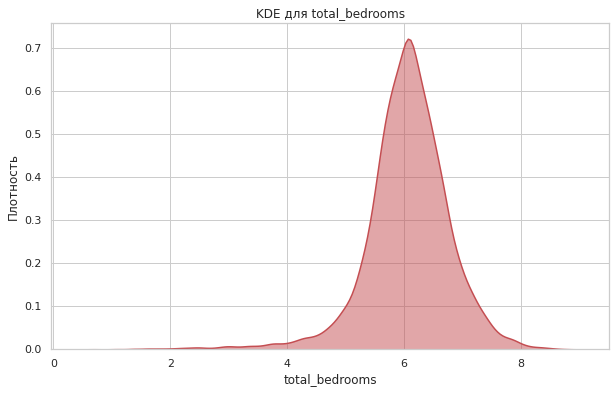

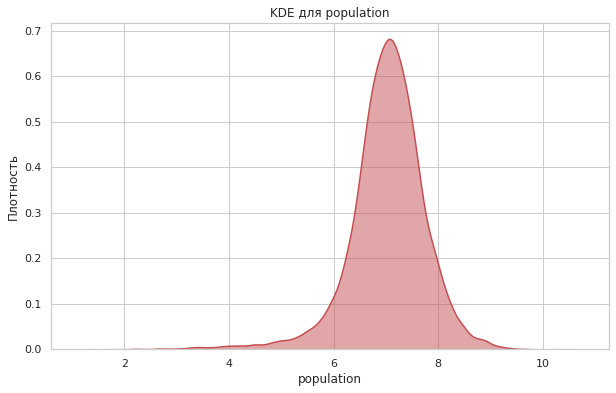

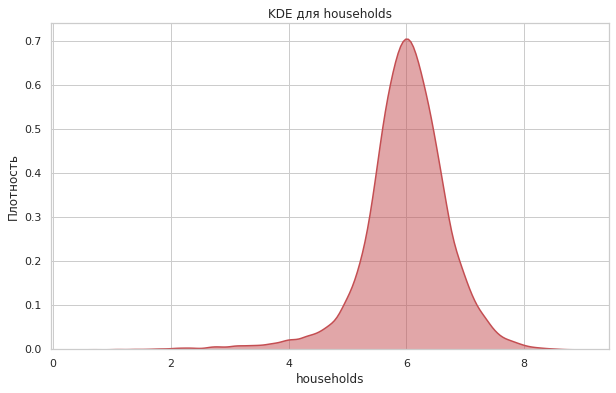

In [34]:
df_num = df['total_rooms',
'total_bedrooms',
'population',
'households']
plot_kde_numeric_features(df_num)

In [35]:
calculate_skewness(df)

Skewness of longitude: -0.29777956498585917
Skewness of latitude: 0.4659191401627141
Skewness of housing_median_age: 0.060326253016608676
Skewness of total_rooms: -1.075454519042874
Skewness of total_bedrooms: -0.9986955264951644
Skewness of population: -1.044010816226511
Skewness of households: -1.0515310016250505
Skewness of median_income: 1.6465370299001063
Skewness of median_house_value: 0.9776922140978437
Skewness of rich_dist: 1.1366714652834615


* Сущесивенно уменьшилось смещение и разброс данных. 
* Распределение случайной величины в переменной стало напоминать нормальное.
* Логарифмическое преобразование можно считать удачным.

In [36]:
df.show()


+---------+--------+------------------+------------------+------------------+------------------+------------------+-------------+------------------+---------------+----------+
|longitude|latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|        households|median_income|median_house_value|ocean_proximity| rich_dist|
+---------+--------+------------------+------------------+------------------+------------------+------------------+-------------+------------------+---------------+----------+
|  -122.23|   37.88|              41.0|  6.78105762593618| 4.867534450455582| 5.777652323222656| 4.844187086458591|       8.3252|          452600.0|       NEAR BAY|  0.920489|
|  -122.22|   37.86|              21.0| 8.867850063029406| 7.009408932708637| 7.784057002639929| 7.037905963447182|       8.3014|          358500.0|       NEAR BAY|0.90443355|
|  -122.24|   37.85|              52.0| 7.291656209174461|  5.25227342804663| 6.208590026096629| 5.181783550292085|     

## Обучение моделей

### Преобразование данных для ML

#### OHE-кодирование

In [37]:
# Инициализация StringIndexer для преобразования категориального признака в числовые индексы
#string_indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")

# Инициализация OneHotEncoder для преобразования числовых индексов в вектор OHE
#onehot_encoder = OneHotEncoder(inputCols=["ocean_proximity_indexed"], outputCols=["ocean_proximity_ohe"])

# Создание Pipeline для применения преобразований
#pipeline = Pipeline(stages=[string_indexer, onehot_encoder])

# Обучение модели и преобразование данных
#model = pipeline.fit(df)
#df_transformed = model.transform(df)
#df_pandas = df_transformed.toPandas()
#print(df_pandas)

In [38]:
#df_transformed.printSchema()

In [39]:
#cat_feature = ['ocean_proximity_ohe']
#target = ['median_house_value']
#num_features = ['longitude', 
#                'latitude', 
 #               'housing_median_age', 
  #              'total_rooms', 
   #             'total_bedrooms', 
    #            'population',
     #           'households',
      #          'median_income',
       #         'rich_dist']

#### Масштабирование

In [40]:
# Создание вектора признаков
#assembler = VectorAssembler(inputCols=num_features, outputCol="features_vector")

# Преобразование данных
#df_vector = assembler.transform(df_transformed)

# Инициализация StandardScaler
#scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features", withStd=True, withMean=True)

# Обучение StandardScaler и преобразование данных
#scaler_model = scaler.fit(df_vector)
#df_scaled = scaler_model.transform(df_vector)
#features = ['features_vector']

#df_pandas = df_scaled.toPandas()
#print(df_pandas)

In [41]:
#df_final = df_scaled.select("median_house_value", "ocean_proximity_ohe",  "features_vector")

#all_features = ['ocean_proximity_ohe', 'features_vector']

#df_final.show()

In [42]:
# Инициализация VectorAssembler
#assembler = VectorAssembler(inputCols=["ocean_proximity_ohe", 
#                                       "features_vector"], outputCol="combined_features")

# Преобразование df_final для создания нового векторного столбца
#df_final = assembler.transform(df_final)
#df_final = df_final.select("median_house_value", 
#                           "ocean_proximity_ohe", 
#                           "features_vector", 
#                           "combined_features")

# Показываем результат
#df_final.show()

### Построение моделей Линейной регресии

Построим и сравним 3 модели:
* Модель после разработки новых признаков со всеми признаками
* Модель после разработки новых признаков только с числовыми признаками
* Модель до разработки новых признаков со всеми признаками

* median_house_value - таргет-признак
* ocean_proximity_ohe - закодированый категориальный признак
* features_vector - вектор признаков без категориального признака
* combined_features - вектор ВСЕХ признаков.

<font color='purple'><b>Комментарий студента:</b></font> 

<font color='darkblue'> Изменим часть с созданием моделей, выполним построение через пайплайны</b></font>

In [44]:
pd.DataFrame(df_pipe.dtypes, columns=['column', 'type'])

,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [45]:
columns = df_pipe.columns
for column in columns:
    check_col = F.col(column).isNull()
    print(column, df_pipe.filter(check_col).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


In [46]:
# Разделение набора данных на обучающий и тестовый
train_data, test_data = df_pipe.randomSplit([0.8, 0.2], seed=12345)

In [47]:
# Определение числовых и категориальных столбцов
num_features = ['longitude', 
                'latitude', 
               'housing_median_age', 
                'total_rooms', 
                'total_bedrooms', 
                'population',
                'households',
                'median_income']
cat_features = ['ocean_proximity']
target = ['median_house_value']

# Шаги пайплайна: 
# Шаг 1: Заполнение пропусков в числовых переменных медианой
imputer = Imputer(inputCols=num_features, outputCols=[f"{col}_imputed" for col in num_features], strategy="median")

# Шаг 2: Масштабирование числовых переменных
scaler = StandardScaler(inputCol="num_features_vector", outputCol="scaled_features")

# Шаг 3: Кодирование категориальных переменных с помощью OHE
string_indexer = StringIndexer(inputCol="ocean_proximity", outputCol="cat_indexed")
onehot_encoder = OneHotEncoder(inputCols=["cat_indexed"], outputCols=["cat_ohe"])

# Векторизация числовых признаков для масштабирования
assembler_num = VectorAssembler(inputCols=[f"{col}_imputed" for col in num_features], outputCol="num_features_vector")

# Векторизация всех признаков для модели
assembler_final = VectorAssembler(inputCols=["scaled_features", "cat_ohe"], outputCol="features")

lr = LinearRegression(featuresCol="features", labelCol="median_house_value")


# Создание пайплайна
pipeline_1 = Pipeline(stages=[imputer, assembler_num, scaler, string_indexer, onehot_encoder, assembler_final, lr])

In [48]:
# Регистрация UDF для логарифмического преобразования
log_udf = udf(lambda x: np.log(x + 1), FloatType())

# Функция для вычисления Евклидова расстояния
def calculate_euclid_dist(longitude, latitude):
    rich_dist1 = [37, -122.5]
    rich_dist2 = [34, -118.5]
    dist1 = np.sqrt((rich_dist1[0]-latitude)**2 + (rich_dist1[1]-longitude)**2)
    dist2 = np.sqrt((rich_dist2[0]-latitude)**2 + (rich_dist2[1]-longitude)**2)
    return float(np.min([dist1, dist2]))

# Регистрация UDF в Spark
hotspot_distance_udf = udf(lambda lon, 
                           lat: calculate_euclid_dist(lon, 
                                                      lat, 
                                                      FloatType()))

In [49]:
class EuclidDistanceTransformer(Transformer, HasInputCols, HasOutputCol):
    """
   1. EuclidDistanceTransformer - пользовательзовательский трансформер для PySpark, наследуемым от базового класса Transformer и интерфейсов HasInputCols и HasOutputCol, что позволяет ему интегрироваться в механизм пайплайнов MLlib PySpark.
   
   2. Метод __init__ инициализирует экземпляр трансформера. В нем вызывается конструктор базового класса и устанавливаются параметры, переданные в трансформер. 
   Параметры inputCols и outputCol указывают на входные колонки (в данном случае широту и долготу) и выходную колонку (расстояние до ближайшей "богатой" точки), соответственно.
   
   3. Метод setParams позволяет задать параметры трансформера через вызов метода с ключевыми аргументами. 
   Это позволяет удобно изменять параметры после инициализации объекта.
   
   4. Метод _transform определяет, как трансформер изменяет входной DataFrame. 
   Он добавляет к DataFrame новую колонку, которая рассчитывается с помощью заранее определенной и зарегистрированной UDF calculate_euclid_dist_udf, примененной к столбцам, указанным в inputCols. 
   Этот метод использует метод withColumn DataFrame API PySpark для добавления или изменения колонки в DataFrame.
  
  !!! ВАЖНО!!!  
   calculate_euclid_dist_udf должна быть определена и зарегистрирована как UDF вне класса трансформера. 
   Эта UDF принимает два аргумента (широту и долготу) и возвращает расстояние до ближайшей "богатой" точки, используя функцию calculate_euclid_dist.
    
    Метод __init__ и init, а также super(EuclidDistanceTransformer, self).__init__() и super(EuclidDistanceTransformer, self).init() используют двойные подчеркивания (`__init__`), так как это правильное определение специальных методов в Python.
    """  
    
    @keyword_only
    def __init__(self, inputCols=None, outputCol=None):
        super(EuclidDistanceTransformer, self).__init__()
        kwargs = self._input_kwargs
        self.setParams(**kwargs)
    
    @keyword_only
    def setParams(self, inputCols=None, outputCol=None):
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    def _transform(self, dataset):
        # Главное не забыть, чтобы calculate_euclid_dist уже зарегистрирована как UDF
        return dataset.withColumn(self.getOutputCol(), calculate_euclid_dist_udf(col(self.getInputCols()[0]), col(self.getInputCols()[1])))

# Регистрация UDF на основе функции calculate_euclid_dist
calculate_euclid_dist_udf = udf(calculate_euclid_dist, DoubleType())


In [50]:
num_features = ['longitude', 
                'latitude', 
               'housing_median_age', 
                'median_income'] 
log_features =  ['total_rooms', 'total_bedrooms', 'population', 'households']
cat_features = ['ocean_proximity'] 
rich_feature = ['rich_dist']

# Шаги пайплайна: 

# Определение Imputer для заполнения пропусков медианными значениями в log_features
imputer = Imputer(inputCols=log_features, outputCols=[f"{col}_imputed" for col in log_features], strategy="median")

# Создание SQLTransformer для логарифмического преобразования
sqlExpr = ["log({0}_imputed + 1) as log_{0}".format(feature) for feature in log_features]
sqlTransformer = SQLTransformer(statement="SELECT *, " + ", ".join(sqlExpr) + " FROM __THIS__")


# Создание экземпляра вашего трансформера
euclidDistTransformer = EuclidDistanceTransformer(inputCols=["longitude", "latitude"], outputCol="rich_dist")


# Создание VectorAssembler для масштабирования всех числовых признаков, включая логарифмически преобразованные
assembler = VectorAssembler(inputCols=num_features + [f"log_{feature}" for feature in log_features] + rich_feature, outputCol="features_vec")
 
# Масштабирование всех признаков
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")

# Создание и применение StringIndexer и OneHotEncoder для категориальных признаков
stringIndexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")
oneHotEncoder = OneHotEncoder(inputCols=["ocean_proximity_indexed"], outputCols=["ocean_proximity_ohe"])

# Финальный VectorAssembler для объединения масштабированных признаков и OHE категориальных признаков
finalAssembler = VectorAssembler(inputCols=["scaled_features", "ocean_proximity_ohe"], outputCol="final_features")

lr = LinearRegression(featuresCol="final_features", labelCol="median_house_value")

# Как же я лююлю Трасформары и ассемблеры ! Вот они все слева направо - 

bts_pipeline = Pipeline(stages=[imputer, # Намджун
                              sqlTransformer, # Чонгук
                              euclidDistTransformer, # Чингачгук
                              assembler, 
                              scaler, # ...
                              stringIndexer, 
                              oneHotEncoder, # Гойко Митич
                              finalAssembler, 
                              lr])

In [51]:
# Шаги пайплайна: 

# Определение Imputer для заполнения пропусков медианными значениями в log_features
imputer = Imputer(inputCols=log_features, outputCols=[f"{col}_imputed" for col in log_features], strategy="median")

# Создание SQLTransformer для логарифмического преобразования
sqlExpr = ["log({0}_imputed + 1) as log_{0}".format(feature) for feature in log_features]
sqlTransformer = SQLTransformer(statement="SELECT *, " + ", ".join(sqlExpr) + " FROM __THIS__")


# Создание экземпляра вашего трансформера
euclidDistTransformer = EuclidDistanceTransformer(inputCols=["longitude", "latitude"], outputCol="rich_dist")


# Создание VectorAssembler для масштабирования всех числовых признаков, включая логарифмически преобразованные
assembler = VectorAssembler(inputCols=num_features + [f"log_{feature}" for feature in log_features] + rich_feature, outputCol="features_vec")
 
# Масштабирование всех признаков
scaler = StandardScaler(inputCol="features_vec", outputCol="scaled_features")



# Финальный VectorAssembler для объединения масштабированных признаков и OHE категориальных признаков
finalAssembler = VectorAssembler(inputCols=["scaled_features"], outputCol="final_features")

lr = LinearRegression(featuresCol="final_features", labelCol="median_house_value")

# BTS но неполным составом...

no_bts_pipeline = Pipeline(stages=[imputer, # Намджун
                              sqlTransformer, # Чонгук
                              euclidDistTransformer, # Чингачгук
                              assembler, 
                              scaler,
                              finalAssembler, 
                              lr])

In [52]:
model_1 = pipeline_1.fit(train_data)
predictions_1 = model_1.transform(test_data)

24/02/16 12:35:05 WARN Instrumentation: [300dc49f] regParam is zero, which might cause numerical instability and overfitting.
24/02/16 12:35:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
24/02/16 12:35:05 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
24/02/16 12:35:06 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
24/02/16 12:35:06 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [53]:
model_2 = bts_pipeline.fit(train_data)
predictions_2 = model_2.transform(test_data)

24/02/16 12:35:12 WARN Instrumentation: [f598098c] regParam is zero, which might cause numerical instability and overfitting.


In [54]:
model_3 = no_bts_pipeline.fit(train_data)
predictions_3 = model_3.transform(test_data)

24/02/16 12:35:17 WARN Instrumentation: [75cd1412] regParam is zero, which might cause numerical instability and overfitting.


In [55]:
# Предполагаем, что predictions_1, predictions_2, predictions_3 уже существуют
predictions_list = [predictions_1, predictions_2, predictions_3]
models_names = ["Модель 1", "Модель 2", "Модель 3"]

# Инициализация оценщиков
evaluatorRMSE = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="rmse")
evaluatorMAE = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="mae")
evaluatorR2 = RegressionEvaluator(labelCol="median_house_value", predictionCol="prediction", metricName="r2")

# Цикл для вычисления и вывода метрик для каждой модели
for predictions, name in zip(predictions_list, models_names):
    rmse = evaluatorRMSE.evaluate(predictions)
    mae = evaluatorMAE.evaluate(predictions)
    r2 = evaluatorR2.evaluate(predictions)
    
    print(f"{name}:")
    print(f"  RMSE: {rmse}")
    print(f"  MAE: {mae}")
    print(f"  R^2: {r2}\n")

Модель 1:
  RMSE: 67710.87612723716
  MAE: 49104.64439816546
  R^2: 0.658833848537691

Модель 2:
  RMSE: 64313.81305680815
  MAE: 46613.89334236302
  R^2: 0.6922078156584819

Модель 3:
  RMSE: 65245.12943707232
  MAE: 47555.72209778754
  R^2: 0.6832291105949324



### Построим модель без создания нового признака и без логарифмических преобразований

In [56]:
# Список числовых признаков
#num_features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 
#                'total_bedrooms', 'population', 'households', 'median_income']

# Шаг 1: Кодирование категориального признака 'ocean_proximity'
#string_indexer = StringIndexer(inputCol="ocean_proximity", outputCol="ocean_proximity_indexed")
#onehot_encoder = OneHotEncoder(inputCols=["ocean_proximity_indexed"], outputCols=["ocean_proximity_ohe"])

# Шаг 2: Векторизация числовых признаков
#assembler_num = VectorAssembler(inputCols=num_features, outputCol="features_vector")

# Шаг 3: Масштабирование векторизованных числовых признаков
#scaler = StandardScaler(inputCol="features_vector", outputCol="scaled_features_vector", withStd=True, withMean=True)

# Шаг 4: Объединение вектора с числовыми признаками и вектора с OHE в один вектор
#assembler_final = VectorAssembler(inputCols=["ocean_proximity_ohe", "scaled_features_vector"], outputCol="final_features_vector")

# Создание Pipeline
#pipeline = Pipeline(stages=[string_indexer, onehot_encoder, assembler_num, scaler, assembler_final])

# Обучение Pipeline и преобразование df_copy
#model = pipeline.fit(df_copy)
#df_transformed2 = model.transform(df_copy)

# Выборка только необходимых столбцов для финального DataFrame
#df_final2 = df_transformed2.select("median_house_value", "final_features_vector")

# Показываем результат
#df_final2.show()

In [57]:
spark.stop()

## Анализ результатов

1. Модель 2 со всеми признаками после обработки данных:
  *   RMSE: 64313.81305680815
  *   MAE: 46613.89334236302
  *   R^2: 0.6922078156584819

2. Модель 3 с числовыми переменными после обработки данных (исключая категориальные признаки):
  *   RMSE: 65245.12943707232
  *   MAE: 47555.72209778754
  *   R^2: 0.6832291105949324

3. Модель 1 без обработки со всеми признаками (без логарифмического преобразования и нового синтетического признака):
  *  RMSE: 67710.87612723716
  *  MAE: 49104.64439816546
  *  R^2: 0.658833848537691


### Результат работы моделей:

- **Улучшение метрик**: Модель, включающая все обработанные признаки, показывает лучшие результаты по сравнению с моделью, в которой использовались только числовые переменные после обработки, а также по сравнению с моделью без предварительной обработки данных. Это указывает на то, что логарифмическое преобразование числовых признаков и введение нового признака, основанного на удаленности от районов с высокой стоимостью жилья, действительно способствуют улучшению качества модели.

- **Важность категориальных признаков**: Включение обработанного категориального признака ocean_proximity через OHE в первую модель улучшило метрики по сравнению со второй моделью, где этот признак был исключен. Это подтверждает ценность категориальных данных при построении моделей машинного обучения.

- **Повышение R2**: Коэффициент детерминации (R2), наивысший у модели со всеми обработанными признаками, указывает на лучшее объяснение вариативности целевой переменной по сравнению с другими моделями. Это свидетельствует о том, что модель способна объяснить большую часть изменчивости цены на жилье.

- **Снижение RMSE и MAE**: Модель со всеми обработанными признаками показала наименьшие значения ошибок RMSE и MAE, что говорит о более точных предсказаниях цены на жилье.

### Общий вывод:
**В рамках проекта были пройдены следующие этапы:**
1. **Преобразование и анализ данных**: Были выполнены различные преобразования данных, включая кодирование категориальных признаков и масштабирование числовых данных. Это подчеркивает значимость правильной предобработки признаков перед использованием их в моделях машинного обучения.
2. **Векторизация признаков**: Применение техник векторизации, таких как One Hot Encoding и сборка признаков в векторы с помощью VectorAssembler, позволило эффективно подготовить данные для обучения модели.
3. **Построение моделей линейной регрессии**: Были построены и оценены модели линейной регрессии на разных наборах признаков, что демонстрирует важность выбора и обработки признаков для достижения наилучшей производительности модели.
4. **Оценка моделей**: Использование метрик RMSE, MAE и R^2 для оценки качества моделей подчеркнуло важность комплексного подхода к оценке моделей машинного обучения.
5. **Анализ результатов**: Сравнение моделей показало, что предварительная обработка данных, включая логарифмическое преобразование и введение синтетических признаков, способствует улучшению показателей модели. Особенно это заметно на примере улучшения метрик для модели со всеми обработанными признаками по сравнению с моделью без предобработки данных и моделью, использующей только числовые признаки.

Этот анализ подчеркивает значимость тщательной предобработки и анализа данных перед построением моделей машинного обучения. Использование PySpark позволяет эффективно обрабатывать большие объемы данных, применяя сложные преобразования и аналитические методы. Результаты моделирования показывают, что интеграция качественной предобработки данных, включая обработку категориальных и числовых признаков, влияет на точность и качество предсказаний моделей. Это подтверждает необходимость комплексного подхода к анализу данных, включая инженерию признаков и тщательный выбор моделей и их параметров, для достижения наилучших результатов в машинном обучении.